In [104]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math
import json

In [2]:
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(EXPERIMENT_NAME)
# EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)

In [3]:
CONVERTED_DATABASE_NAME = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [213]:
FEATURES_DIR = "{}/features-3did".format(EXPERIMENT_DIR)
FEATURES_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)

In [214]:
d = pd.read_pickle('{}/features-3did/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.pkl'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME))
features_df = d['features_df']
features_df.reset_index(drop=True, inplace=True)

In [215]:
len(features_df)

302

In [216]:
features_df.sample(n=3)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,monoisotopic_mass,feature_intensity,envelope,isotope_count,deconvolution_score,feature_region_3d_extent,voxel_metadata_d,scan_df,rt_df,feature_id
83,713.828300,713.873772,567.0,550,572,1670.554030,1667.908146,1673.198998,2467,2467,...,1425.687520,2467,"[[713.8510362671723, 10521.0], [714.3523196218...",4,253.886626,"{'mz_lower': 713.2191116073099, 'mz_upper': 71...","{'mz_lower': 713.7688603510285, 'mz_upper': 71...","[{'scan': 537, 'intensity': 129, 'filtered_int...","[{'frame_id': 14707, 'retention_time_secs': 16...",83
249,704.397396,704.442267,591.0,577,618,1679.552152,1676.905255,1679.552152,551,551,...,1406.825110,551,"[[704.4198312379644, 2197.0], [704.92052114641...",4,122.298219,"{'mz_lower': 703.2693628635913, 'mz_upper': 70...","{'mz_lower': 703.8191116073099, 'mz_upper': 70...","[{'scan': 577, 'intensity': 9, 'filtered_inten...","[{'frame_id': 14782, 'retention_time_secs': 16...",249
38,717.865115,717.910844,583.0,561,600,1661.029752,1658.383374,1664.204048,4504,4504,...,1433.761406,4504,"[[717.8879792311225, 32892.0], [718.3873878379...",4,489.472814,"{'mz_lower': 717.2392121098225, 'mz_upper': 72...","{'mz_lower': 717.7889608535411, 'mz_upper': 71...","[{'scan': 548, 'intensity': 45, 'filtered_inte...","[{'frame_id': 14632, 'retention_time_secs': 16...",38


In [274]:
selected_feature = features_df.loc[200]

#### isotope extent in mobility

In [275]:
scan_df = pd.DataFrame(selected_feature.scan_df)

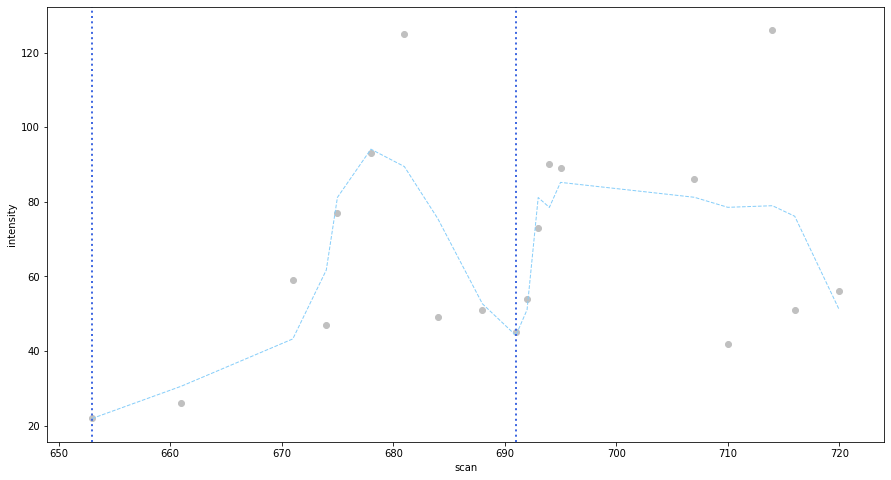

In [276]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_df.scan, scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.axvline(x=selected_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2)
plt.axvline(x=selected_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

#### isotope extent in retention time

In [277]:
rt_df = pd.DataFrame(selected_feature.rt_df)

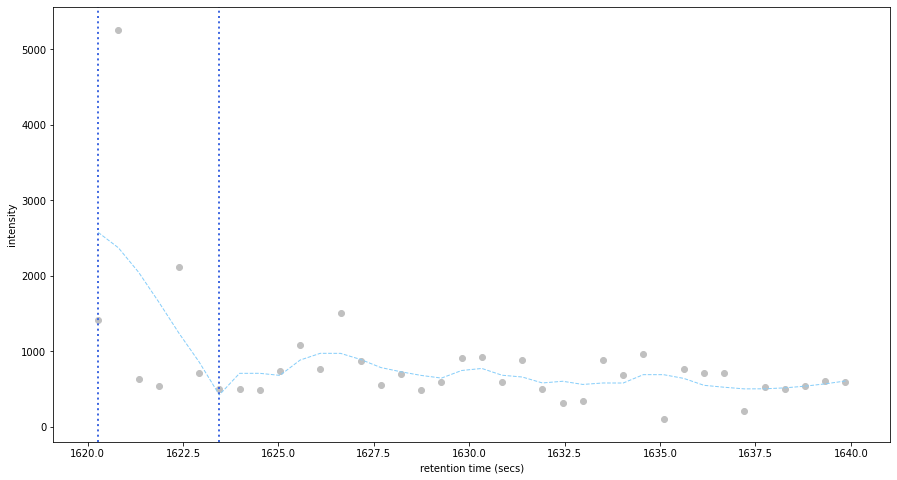

In [278]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_df.retention_time_secs, rt_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')

plt.axvline(x=selected_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2)
plt.axvline(x=selected_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()

#### feature region in the voxel's most intense frame

In [279]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)


In [280]:
selected_feature

mono_mz_lower                                                                        701.826
mono_mz_upper                                                                        701.871
scan_apex                                                                                678
scan_lower                                                                               653
scan_upper                                                                               691
rt_apex                                                                              1620.28
rt_lower                                                                             1620.28
rt_upper                                                                             1623.45
intensity_without_saturation_correction                                                  722
intensity_with_saturation_correction                                                     722
mono_intensity_adjustment_outcome                                 mono

In [281]:
selected_feature.voxel_metadata_d

{'mz_lower': 700.3015236676114,
 'mz_upper': 700.4020261801743,
 'scan_lower': 678,
 'scan_upper': 707,
 'rt_lower': 1628.2759204823533,
 'rt_upper': 1632.2759204823533,
 'mz_centroid': 700.350156334534,
 'iso_mz_lower': 700.3278504845221,
 'iso_mz_upper': 700.3724621845458,
 'voxel_scan_midpoint': 692.5,
 'voxel_rt_midpoint': 1630.2759204823533,
 'voxel_rt_highpoint_frame_id': 14412,
 'frame_region_scan_lower': 652.5,
 'frame_region_scan_upper': 732.5}

In [282]:
scan_lower = min(selected_feature.scan_lower, selected_feature.voxel_metadata_d['scan_lower'], selected_feature.feature_region_3d_extent['scan_lower'])
scan_upper = max(selected_feature.scan_upper, selected_feature.voxel_metadata_d['scan_upper'], selected_feature.feature_region_3d_extent['scan_upper'])

In [283]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(selected_feature.rt_apex-20, selected_feature.rt_apex+20, scan_lower, scan_upper, selected_feature.feature_region_3d_extent['mz_lower'], selected_feature.feature_region_3d_extent['mz_upper']), db_conn)
db_conn.close()

In [284]:
voxel_most_intense_frame_id = selected_feature.voxel_metadata_d['voxel_rt_highpoint_frame_id']
voxel_most_intense_frame_df = raw_df[(raw_df.frame_id == voxel_most_intense_frame_id)]

In [285]:
len(voxel_most_intense_frame_df)

254

In [286]:
voxel_mz_lower = selected_feature.voxel_metadata_d['mz_lower']
voxel_mz_upper = selected_feature.voxel_metadata_d['mz_upper']
voxel_scan_lower = selected_feature.voxel_metadata_d['scan_lower']
voxel_scan_upper = selected_feature.voxel_metadata_d['scan_upper']

In [287]:
base_peak_mz_lower = selected_feature.voxel_metadata_d['iso_mz_lower']
base_peak_mz_upper = selected_feature.voxel_metadata_d['iso_mz_upper']
base_peak_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
base_peak_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']

In [288]:
feature_region_mz_lower = selected_feature.feature_region_3d_extent['mz_lower']
feature_region_mz_upper = selected_feature.feature_region_3d_extent['mz_upper']
feature_region_scan_lower = selected_feature.feature_region_3d_extent['scan_lower']
feature_region_scan_upper = selected_feature.feature_region_3d_extent['scan_upper']
feature_region_rt_lower = selected_feature.feature_region_3d_extent['rt_lower']
feature_region_rt_upper = selected_feature.feature_region_3d_extent['rt_upper']

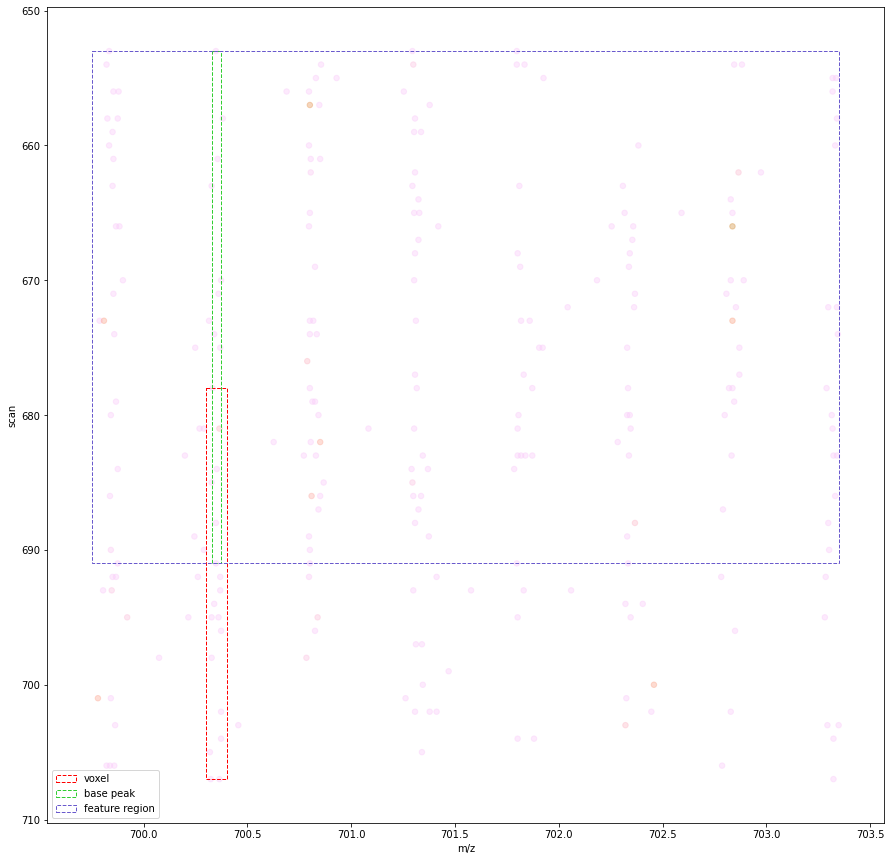

In [289]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(voxel_most_intense_frame_df.mz, voxel_most_intense_frame_df.scan, c=voxel_most_intense_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)
# plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the voxel
top_left = (voxel_mz_lower,voxel_scan_lower)
width = voxel_mz_upper - voxel_mz_lower
height = voxel_scan_upper - voxel_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='red',facecolor='none',label='voxel')
ax1.add_patch(cuboid_rect)

# draw the base peak
top_left = (base_peak_mz_lower,base_peak_scan_lower)
width = base_peak_mz_upper - base_peak_mz_lower
height = base_peak_scan_upper - base_peak_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='limegreen',facecolor='none',label='base peak')
ax1.add_patch(cuboid_rect)

# draw the feature region for deconvolution
top_left = (feature_region_mz_lower,feature_region_scan_lower)
width = feature_region_mz_upper - feature_region_mz_lower
height = feature_region_scan_upper - feature_region_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(voxel_most_intense_frame_df.mz.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(voxel_most_intense_frame_df.scan.min() / nearest) * nearest
range_u = round(voxel_most_intense_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [290]:
feature_region_raw_df = raw_df[(raw_df.mz >= feature_region_mz_lower) & (raw_df.mz <= feature_region_mz_upper) & (raw_df.scan >= feature_region_scan_lower) & (raw_df.scan <= feature_region_scan_upper) & (raw_df.retention_time_secs >= feature_region_rt_lower) & (raw_df.retention_time_secs <= feature_region_rt_upper)].copy()
feature_region_raw_df['normalised_intensity'] = feature_region_raw_df.intensity / feature_region_raw_df.intensity.max()

In [291]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

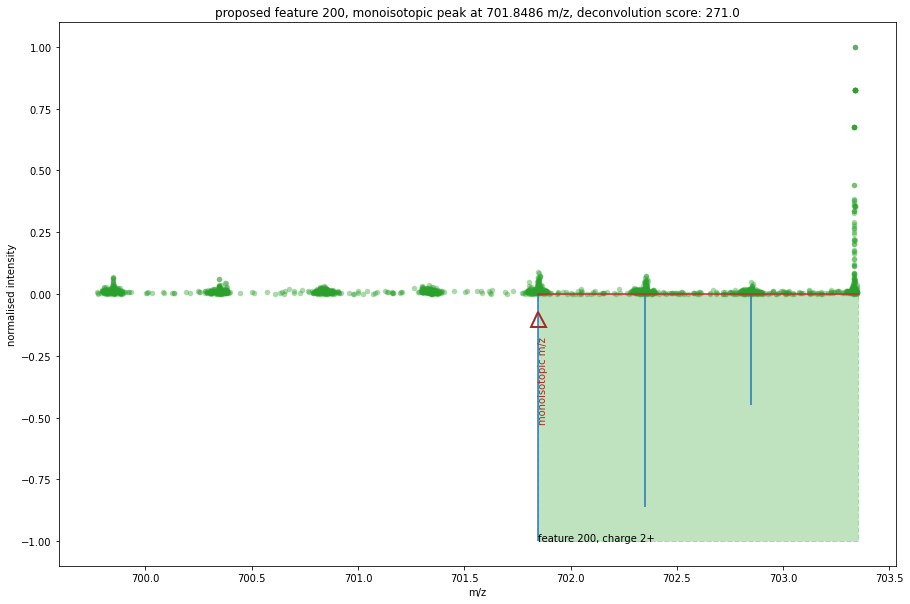

In [292]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(feature_region_raw_df.mz, feature_region_raw_df.normalised_intensity, marker='o', color='tab:green', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(selected_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(selected_feature.feature_id, selected_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(selected_feature.mono_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(selected_feature.mono_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(feature_region_raw_df.mz.min() / nearest) * nearest
range_u = round(feature_region_raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

ax.set_title('proposed feature {}, monoisotopic peak at {} m/z, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), round(selected_feature.deconvolution_score,1)))

plt.show()